In [1]:
library(Matrix)
library(mvtnorm)
library(hexbin)
library(ggplot2)

In [2]:
# set the plot sizes to be full width
library(repr)

# Define parameters
- number of features (`nGenes`)
- number of guides in guide library (`nGuides`)
- number of cells in simulated dataset (`nCells`)
- number of S cycle genes (`n.s.genes`) - represented by genes with index `1:n.s.genes` 
- number of G2M cycle genes (`n.g2m.genes`) - represented by genes with index `n.s.genes + 1:n.s.genes + n.g2m.genes + 1`
- proportion of cells in dataset in S phase (`propS`)
- proportion of cells in dataset in G2 phase (`propG2`)

In [7]:
nGenes=13000
# nGuides=6000
# nGuides = 2000
nTargets = 1000
# nCells=250000
nCells = 50000
d = 2
nGuides = d*nTargets

# Look at Gasperini count data

Randomly select 1000 genes from experimental data and fit a NB distribution to the counts across all cells to get a sense of what values of $\mu$ (`mu`) and $n$ (`disp`) describe the scRNA-seq count data. We will parameterize $\mu$ as $\mu=s \cdot \exp{(\beta_0)}$ where $s$ is a scaling factor accounting for sequencing depth. We define $s$ as $s=\frac{T}{1e6}$ where $T=\mbox{total reads observed in a cell}$. We will use the distribution of estimated $\beta_0$ values to help pick values for our simulation.

In [5]:
gasperini.counts <- readMM("/iblm/netapp/data1/external/Gasperini2019/processed/GSE120861_at_scale_screen.exprs.mtx.gz")

In [6]:
dim(gasperini.counts)

[1]  13135 207324

In [6]:
# subsample to 10000 cells for speed and convert from dgTmatrix to regular matrix (faster to access data)
gasperini.counts.sub <- gasperini.counts[,sample(1:dim(gasperini.counts)[2], 10000)]
gasperini.counts.sub.mtx <- as.matrix(gasperini.counts.sub)

In [60]:
# calculate total counts in data (used for previous calculation of scaling factor)
totCounts <- sum(colSums(gasperini.counts.sub.mtx))
totCounts

[1] 182461739

In [8]:
# scaling.factors <- colSums(gasperini.counts.sub.mtx)/totCounts
scaling.factors <- colSums(gasperini.counts.sub.mtx)/1e6

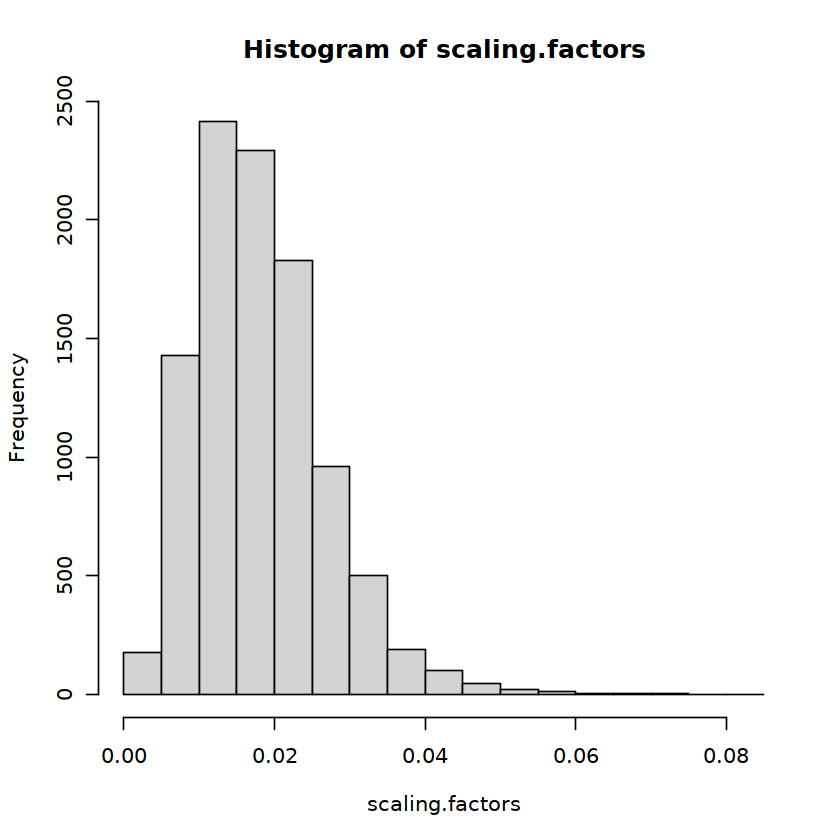

In [9]:
hist(scaling.factors)

In [11]:
png("../gasperini_scaling_factors_hist.png")
hist(scaling.factors)
dev.off()

png 
  2

Observe counts across cells for a random gene in dataset.

[1] 4955

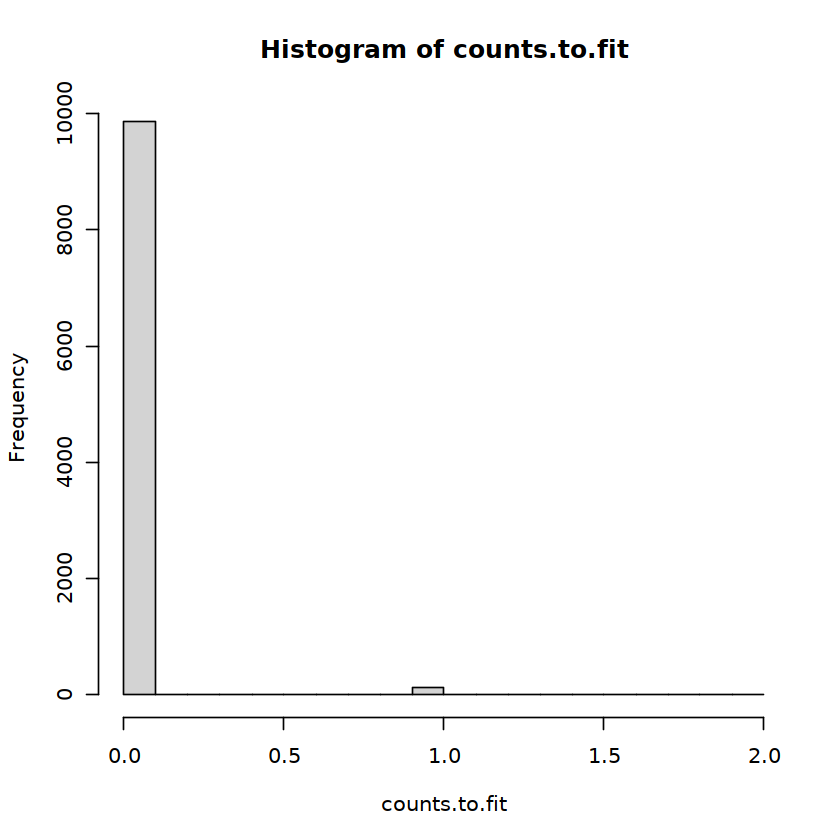

In [7]:
# select random gene to sample
sample.gene <- sample(1:ncol(gasperini.counts.sub.mtx), 1)
sample.gene

counts.to.fit <- gasperini.counts.sub.mtx[sample.gene,]
hist(counts.to.fit)

Define optimization function for fitting NB to count data (by gene)

In [231]:
my_optim <- function(par, data, scale){
    # par[1] = beta0
    # par[2] = sqrt(disp)
    beta0 <- par[1]
    d <- par[2]^2
    mu <- scale*exp(beta0)
    -sum(dnbinom(data, mu = mu, size = d, log = T))
}

In [15]:
optim.out <- optim(c(1, 1), my_optim, data = counts.to.fit, scale = scaling.factors, method= 'L-BFGS-B')
print(optim.out)

$par
[1] -0.2575601  0.3750052

$value
[1] 728.7145

$counts
function gradient 
      18       18 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"



### Iterate through 1000 genes

Fit NB to counts for each gene

In [16]:
beta0.list <- c()
disp.list <- c()
j <- 1

for (i in sample(1:nrow(gasperini.counts.sub), 1000)) {
    counts.to.fit <- gasperini.counts.sub.mtx[i,]
    params <- optim(c(8,1), my_optim, data = counts.to.fit , scale = scaling.factors, method= 'L-BFGS-B')
#     cat(sprintf("beta0 = %.3f, disp = %.3f\n", params$par[1], sqrt(abs(params$par[2]))))
    beta0.list[j] <- params$par[1]
    disp.list[j] <- sqrt(abs(params$par[2]))
    j <- j + 1
}

##### Visualize distribution of estimated $\beta_0$ values

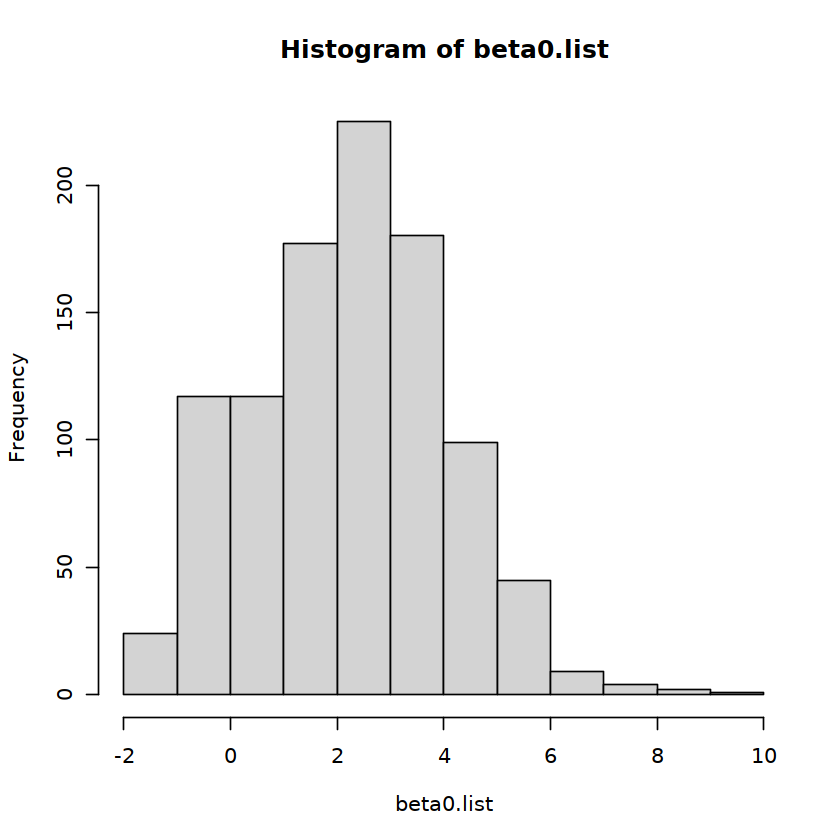

In [17]:
hist(beta0.list)

In [18]:
png("../beta0_1000_hist.png")
hist(beta0.list)
dev.off()

png 
  2

##### Visualize distribution of estimated `disp` values

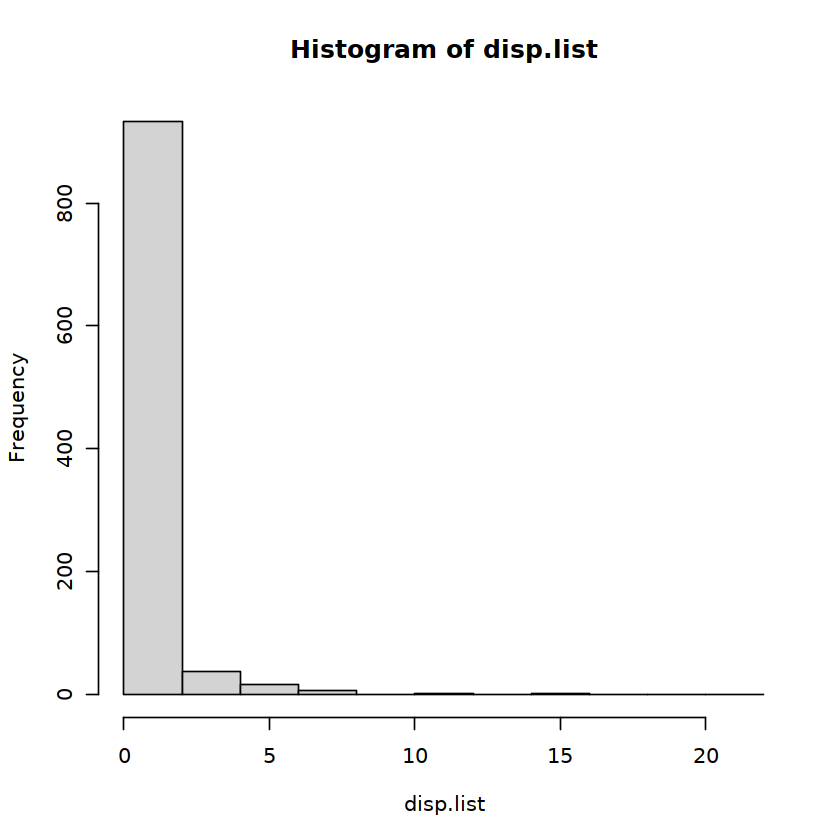

In [19]:
hist(disp.list)

In [21]:
png("../disp_1000_hist.png")
hist(disp.list)
dev.off()

png 
  2

Look at mean/mode of estimated dispersion values.

In [47]:
mean(disp.list)

[1] 1.491409

In [52]:
table(round(disp.list,2))


  0.3  0.34  0.37   0.4  0.41  0.42  0.44  0.45  0.46  0.48  0.49   0.5  0.51 
    1     1     2     1     2     1     1     1     1     3     2     3     2 
 0.53  0.54  0.55  0.56  0.57  0.59   0.6  0.61  0.62  0.63  0.64  0.65  0.66 
    1     2     1     2     2     2     1     6     2     1     4     5     2 
 0.67  0.68  0.69   0.7  0.71  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79 
    4     3     4     3     4     5     1     7     1     5     4     8     2 
  0.8  0.81  0.82  0.83  0.84  0.85  0.86  0.87  0.88  0.89   0.9  0.91  0.92 
    6     2     6     3     4     4     6     7     8     7     2     4     6 
 0.93  0.94  0.95  0.96  0.97  0.98  0.99     1  1.01  1.02  1.03  1.04  1.05 
    2     6     4     5     6     5     4     9     7     8     6     4     6 
 1.06  1.07  1.08  1.09   1.1  1.11  1.12  1.13  1.14  1.15  1.16  1.17  1.18 
   11     1     5    10     9     4     4     8    13    14    11     9    12 
 1.19   1.2  1.21  1.22  1.23  1.24  1.25  1.26  1.

Based on this, `disp=1.5` appears to be a good value to use for downstream simulations.

### Fit estimated $\beta_0$ values to a normal distribution

Previously used gamma because estimation of $\beta_0$ with old definition of scaling factor yielded all non-negative values for $\beta_0$.

In [39]:
optim_gamma <- function(par, data){
    -sum(dgamma(data, shape = par[1], scale = par[2], log = TRUE))
}

optim_norm <- function(par, data) {
    -sum(dnorm(data, mean = par[1], sd = par[2], log = TRUE))
}

In [40]:
# optim(c(1,1), optim_gamma, data = beta0.list, method = "L-BFGS-B")
optim(c(1,1), optim_norm, data = beta0.list, lower = c(-Inf, 1e-10), upper = c(Inf, Inf), method = "L-BFGS-B")

$par
[1] 2.242336 1.811278

$value
[1] 2012.971

$counts
function gradient 
      10       10 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

Visualize distribution of 10000 randomly sample values from a normal distribution defined by these parameter estimates to see if this distribution resembles the distribution of our empirical estimates.

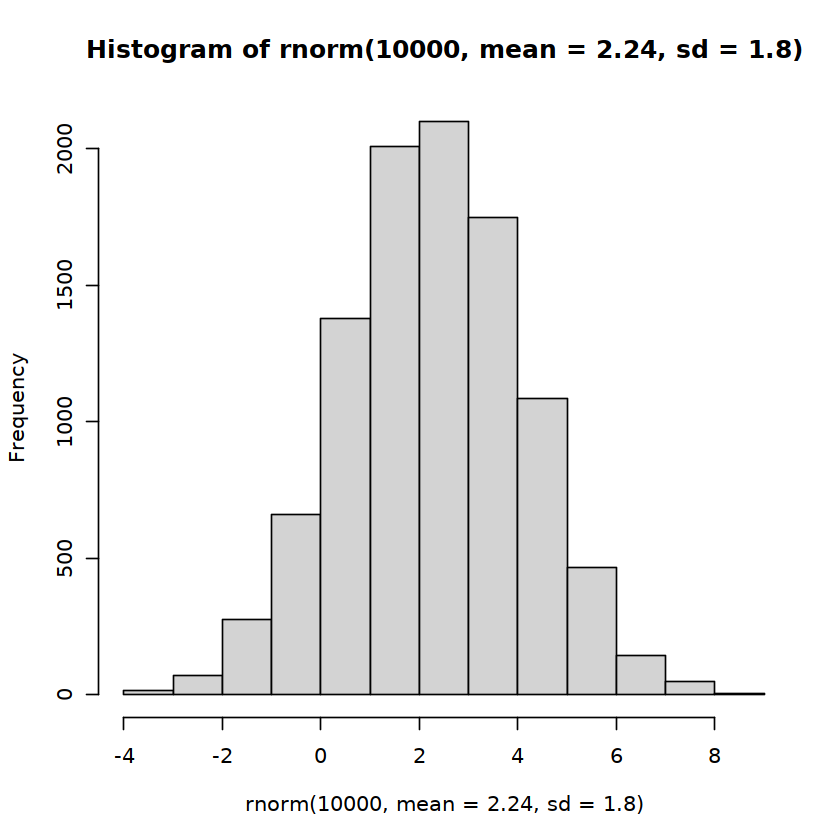

In [44]:
hist(rnorm(10000, mean = 2.24, sd = 1.8))

In [45]:
png("../rnorm_for_beta0_hist.png")
hist(rnorm(10000, mean = 2.24, sd = 1.8))
dev.off()

png 
  2

### Fit dispersion estimates from empirical data to gamma distribution
Just to see

In [54]:
optim(c(1,1), optim_gamma, data = disp.list, method = "L-BFGS-B")

$par
[1] 3.7563472 0.3970389

$value
[1] 1062.118

$counts
function gradient 
      26       26 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

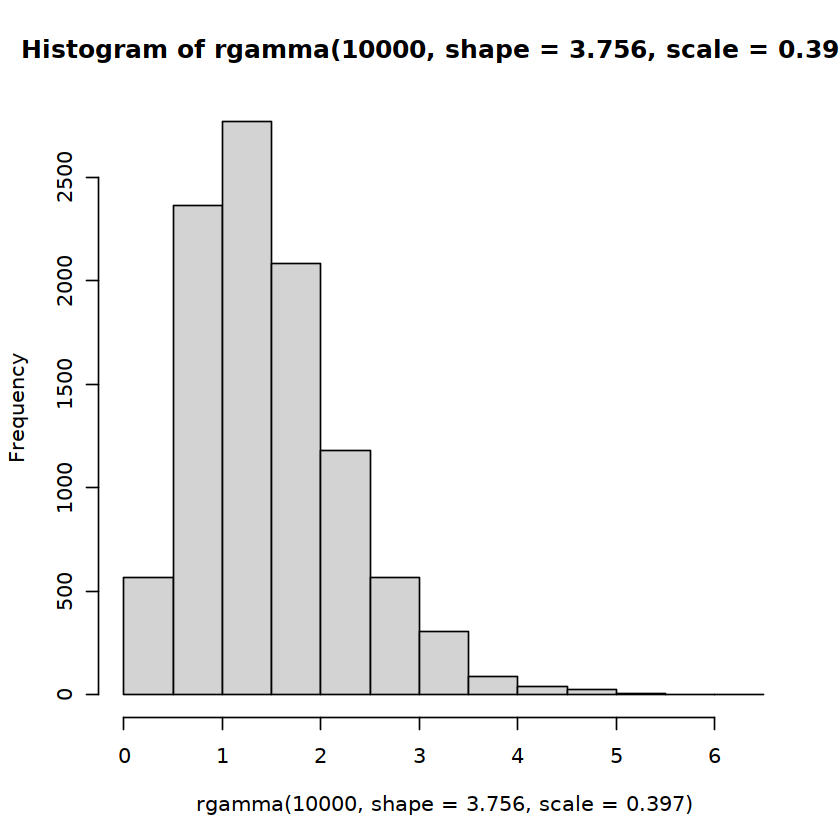

In [55]:
hist(rgamma(10000, shape = 3.756, scale = 0.397))

In [56]:
png("../rgamma_for_disp_hist.png")
hist(rgamma(10000, shape = 3.756, scale = 0.397))
dev.off()

png 
  2

# Assign baseline expression covariate $\beta_0$

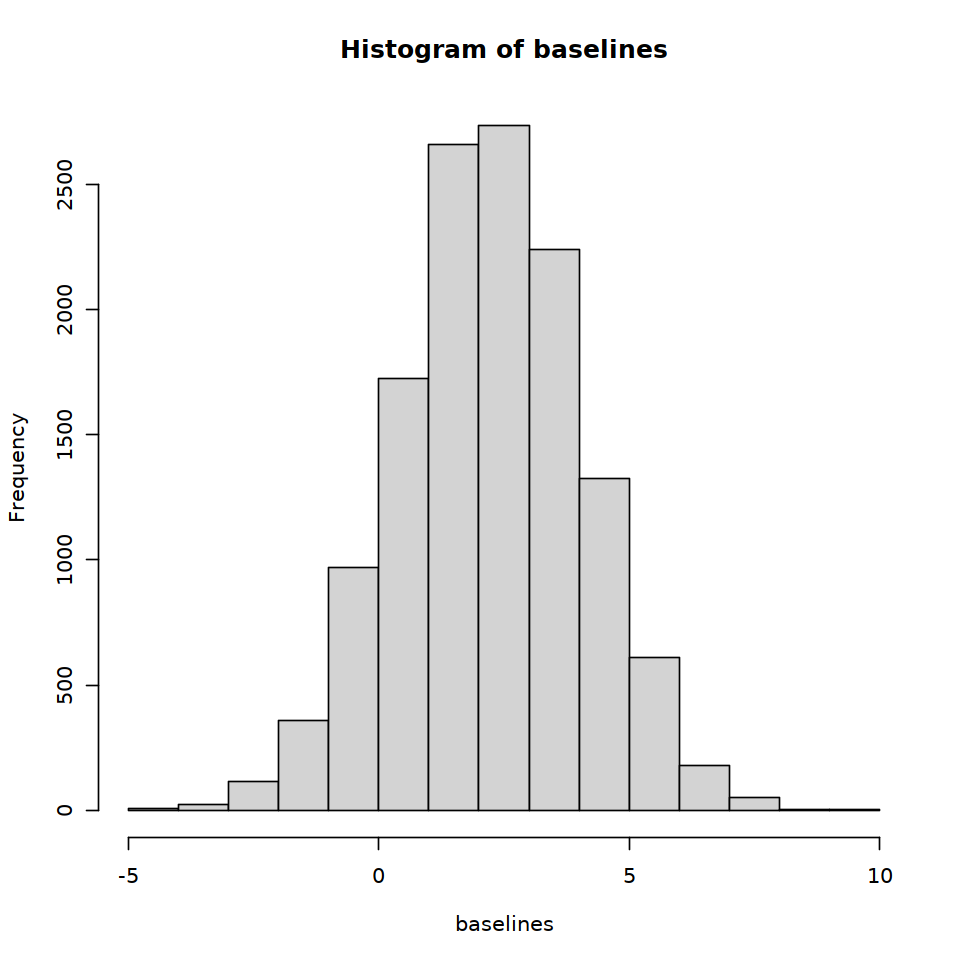

In [74]:
# baselines <- rgamma(nGenes, shape = 16, scale = 0.5)
baselines <- rnorm(nGenes, mean = 2.24, sd = 1.8)
hist(baselines)

In [75]:
png("../hist_beta0_for_simulation.png")
hist(baselines)
dev.off()

png 
  2

# Assign guides to cells

#### 1. Create 0 matrix with `nrow = nCells` and `ncols = nGuides` which will become one hot encoding of guide presence

In [42]:
onehot.guides <- matrix(0, nCells, nGuides)
dim(onehot.guides)

[1] 50000  2000

#### 2. Define parameters for sampling number of guides per cell (ignoring cells per guide for now)

`lambda` = $\lambda$ parameter for `rpois()`


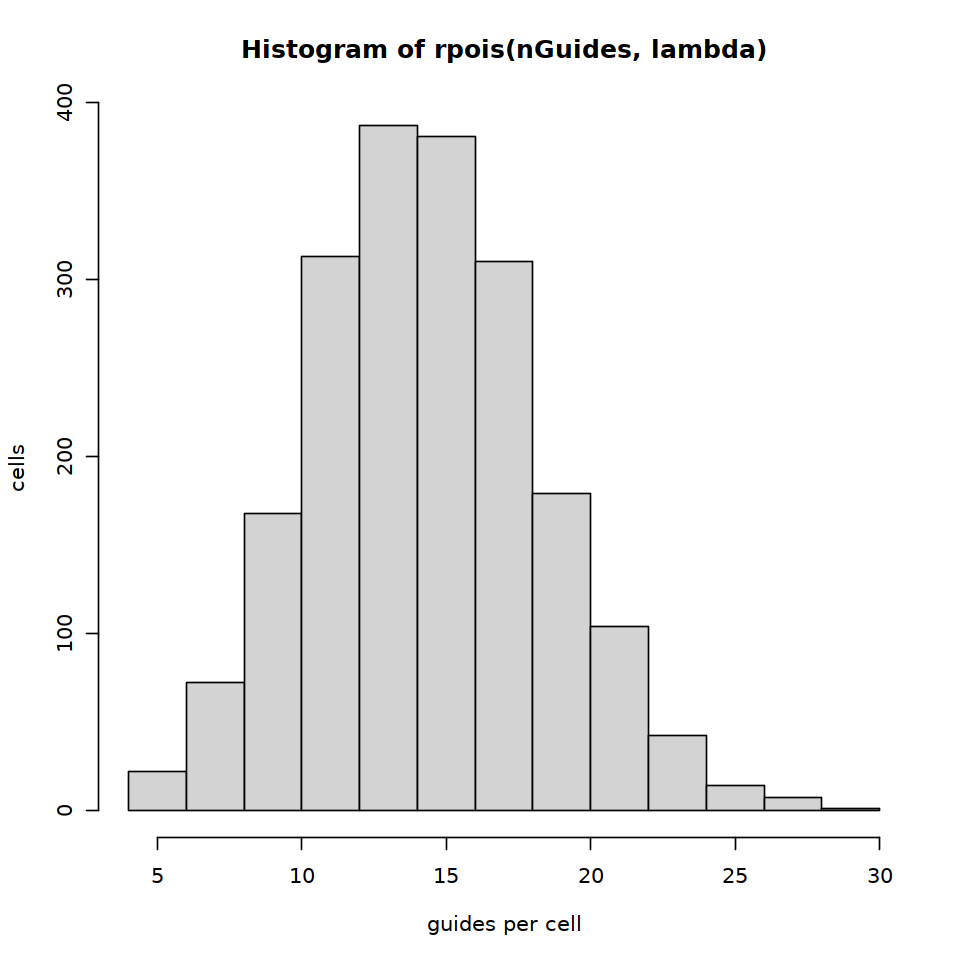

In [43]:
lambda=15
hist(rpois(nGuides, lambda), xlab = "guides per cell", ylab = "cells") 

In [44]:
png("../hist_guides_per_cell.png")
hist(rpois(nGuides, lambda), xlab = "guides per cell", ylab = "cells") 
dev.off()

png 
  2

**3. Assign number of guides per cell**

For each cell, use `rpois(nGuides, lambda)` to sample for # of guides in cell 

In [45]:
guides.per.cell <- rpois(nCells, lambda)

**4. Assign which guides are in each cell**

For each cell, sample an integer from `1:nGuides` without replacement for `guides.per.cell[i]` times, where `i` is the index of the cell.

Use `sample(1:nGuides, nGuides.cell)` to sample for indexes of guides in library

In [46]:
guides.idx.list <- sapply(guides.per.cell, function(x) {sample(1:nGuides, x, replace = FALSE)})

#### 5. Update one hot encoding of guide presence in cells

In [47]:
for (i in 1:nCells) {
    guides.idx <- guides.idx.list[[i]]
    onehot.guides[i, guides.idx] <- 1
}

In [48]:
# check that rowSums of one hot encoding matches the simulated guides.per.cell
all(rowSums(onehot.guides) == guides.per.cell)

[1] TRUE

#### 6. Visualize distribution of guides per cell for simulate data

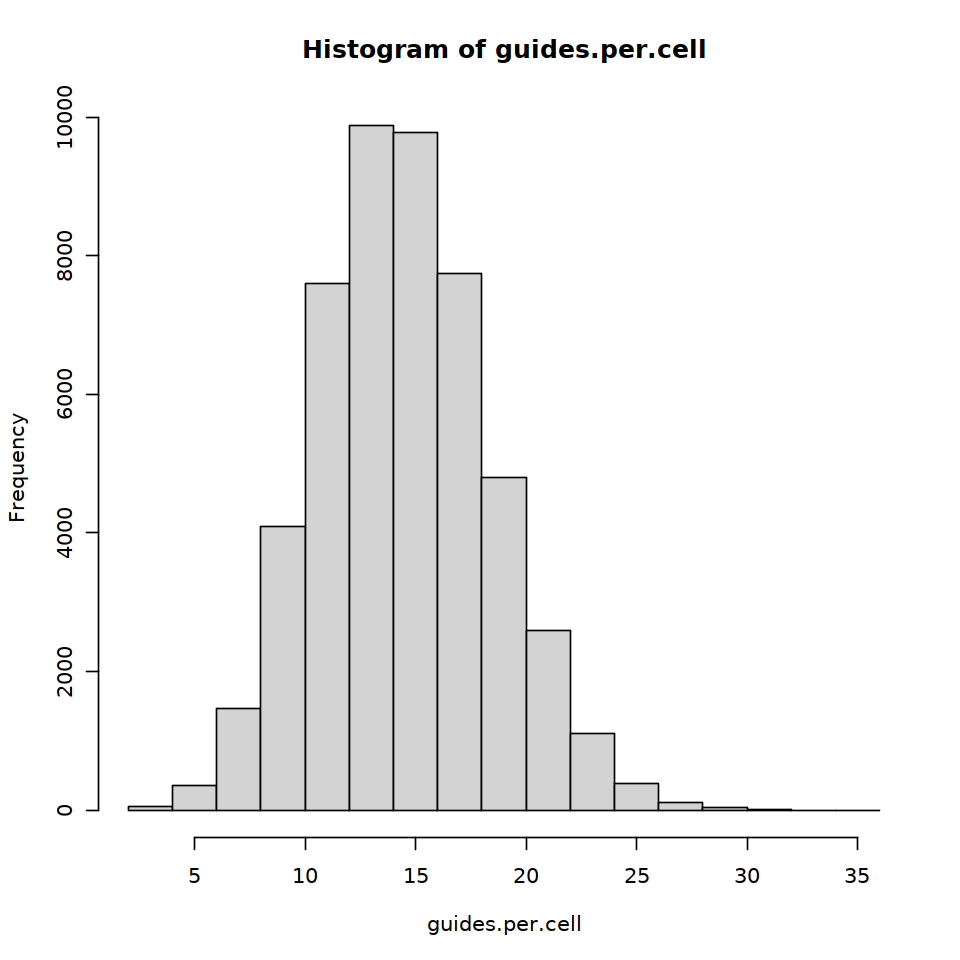

In [49]:
hist(guides.per.cell)

#### 7. Write data to file in Matrix Market format (sparse matrix)

- `guides_per_cell.mtx`

In [50]:
writeMM(Matrix(onehot.guides, sparse = TRUE), "../sim_data_nb/metadata/guides_per_cell.mtx")

NULL

# Assign target genes to guides

For each guide target (candidate enhancer), randomly sample an integer from `1:nGenes` and then repeat the output vector `d` times to select the target gene of the enhancer. This generates a gRNA to target gene mapping.

In [94]:
target.genes <- sample(1:nGenes, nTargets, replace = FALSE)
guide.gene.map <- rep(target.genes, d)

# Assign guide efficiencies to guides in library

Sample from a [beta distribution](hist(rbeta(10000,6,3)))

`rbeta(n, shape1, shape2, ncp = 0)`

where `shape1 = a` and `shape2 = b`,

$\mu = \frac{a}{a+b}$,

$\sigma=\frac{ab}{(a+b)^2(a+b+1)}$,

and $\text{mode}=\frac{a-1}{a+b-2}$ if $a,b>1$ or $(a|b)=1$

In [96]:
# sample guide efficiencies for each guide
efficiencies <- rbeta(nGuides, 6,3)

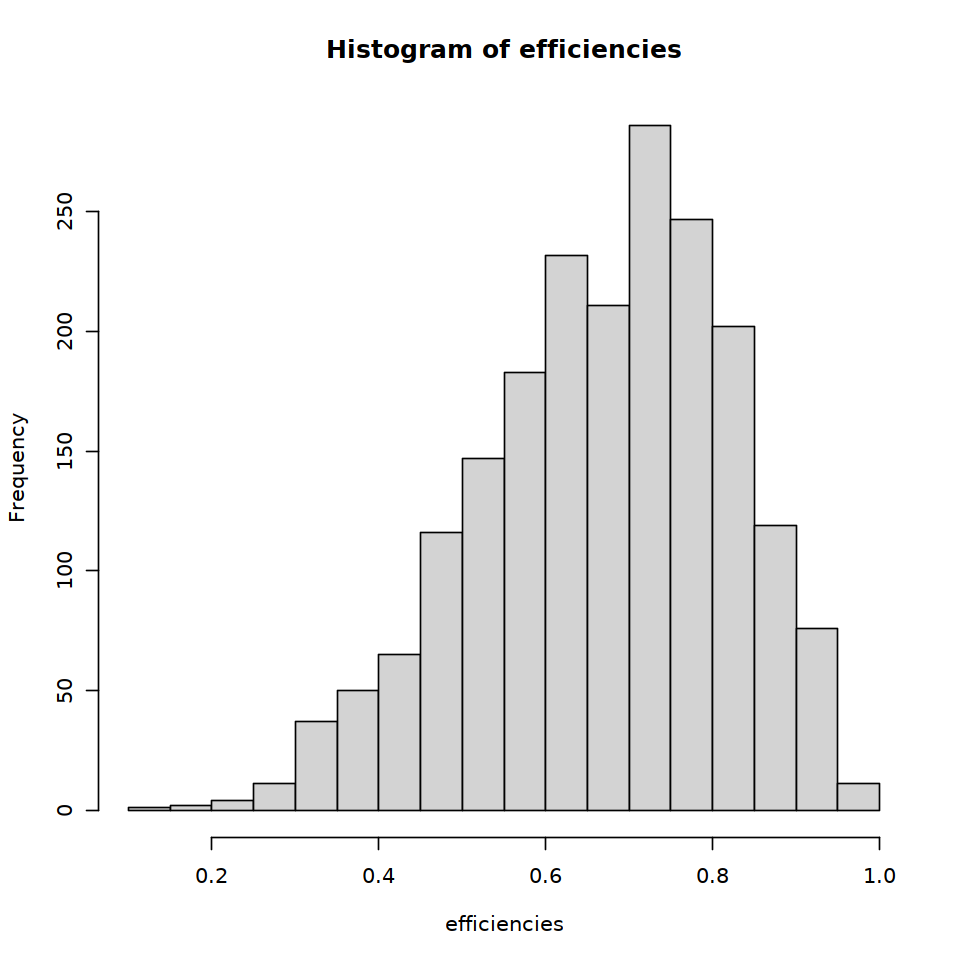

In [97]:
# visualize example of random values sampled from beta distribution
hist(efficiencies)

In [98]:
png("../hist_guide_efficiencies.png")
hist(efficiencies)
dev.off()

png 
  2

# Assign effect size of each target gene's enhancer on expression 

The enhancer's effect on its target gene's expression should be negative since we expect that repressing the enhacner will decrease the gene's expression. While we want these values to be comparable in scale to the values of $\beta_0$, we also do not want them to be too close to 0 because that will make the difference in expression smaller and therefore more difficult to detect with our model. Thus, enhancer effect sizes will be sampled from a gamma distribution, to ensure that all of the values have the same sign and can easily be inverted by multiplying by -1, with a non-zero point mass. We will plot some gamma distributions with different parameters to visualize.

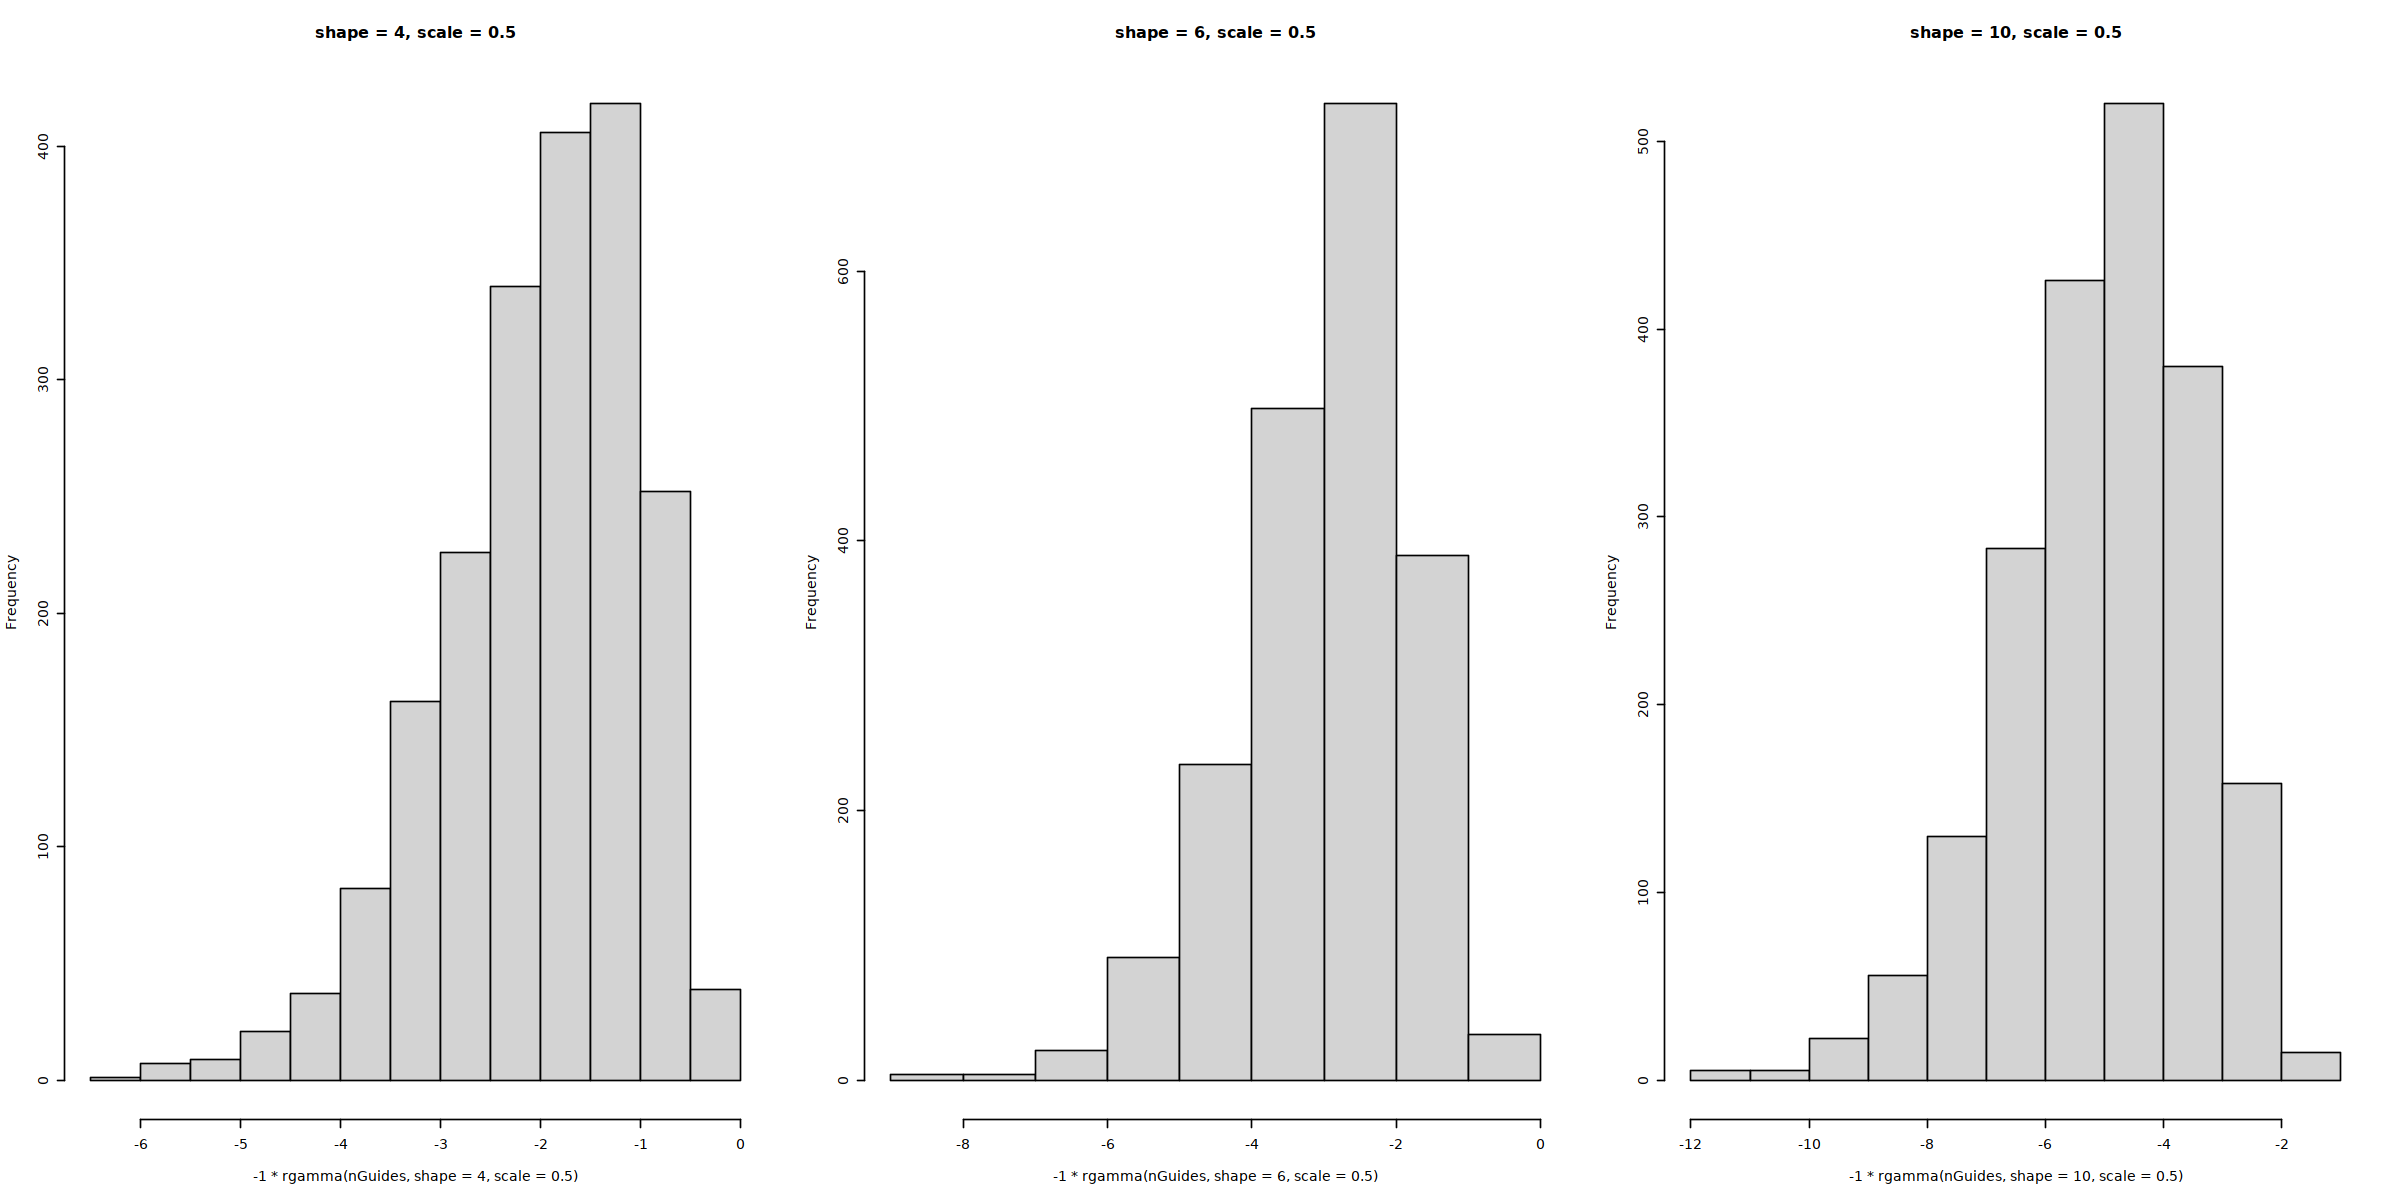

In [99]:
# Change plot size to BIG
options(repr.plot.width=20, repr.plot.height=10)

par(mfrow=c(1,3))
hist(-1*rgamma(nGuides, shape = 4, scale = 0.5), main = "shape = 4, scale = 0.5")
hist(-1*rgamma(nGuides, shape = 6, scale = 0.5), main = "shape = 6, scale = 0.5")
hist(-1*rgamma(nGuides, shape = 10, scale = 0.5), main = "shape = 10, scale = 0.5")

In [100]:
png("../enhancer_effects_gamma_hists.png", units = "cm", width = 20, height = 10, res = 300)
par(mfrow=c(1,3))
hist(-1*rgamma(nGuides, shape = 4, scale = 0.5), main = "shape = 4, scale = 0.5")
hist(-1*rgamma(nGuides, shape = 6, scale = 0.5), main = "shape = 6, scale = 0.5")
hist(-1*rgamma(nGuides, shape = 10, scale = 0.5), main = "shape = 10, scale = 0.5")
dev.off()

png 
  2

**We will proceed with the gamma distribution defined by $\Gamma \left( \alpha = 6, \sigma = 0.5 \right) $.** We are only sampling `nGuides` times, since genes for which we have not designed a gRNA to target its enhancer will see no change in expression.

In [101]:
options(repr.plot.width=8, repr.plot.height=8)

In [102]:
effect.sizes <- -1*(rgamma(nTargets, shape = 6, scale = 0.5))
# effect.sizes <- -1*rnorm(nGuides, mean = 2.24, sd = 1.8)

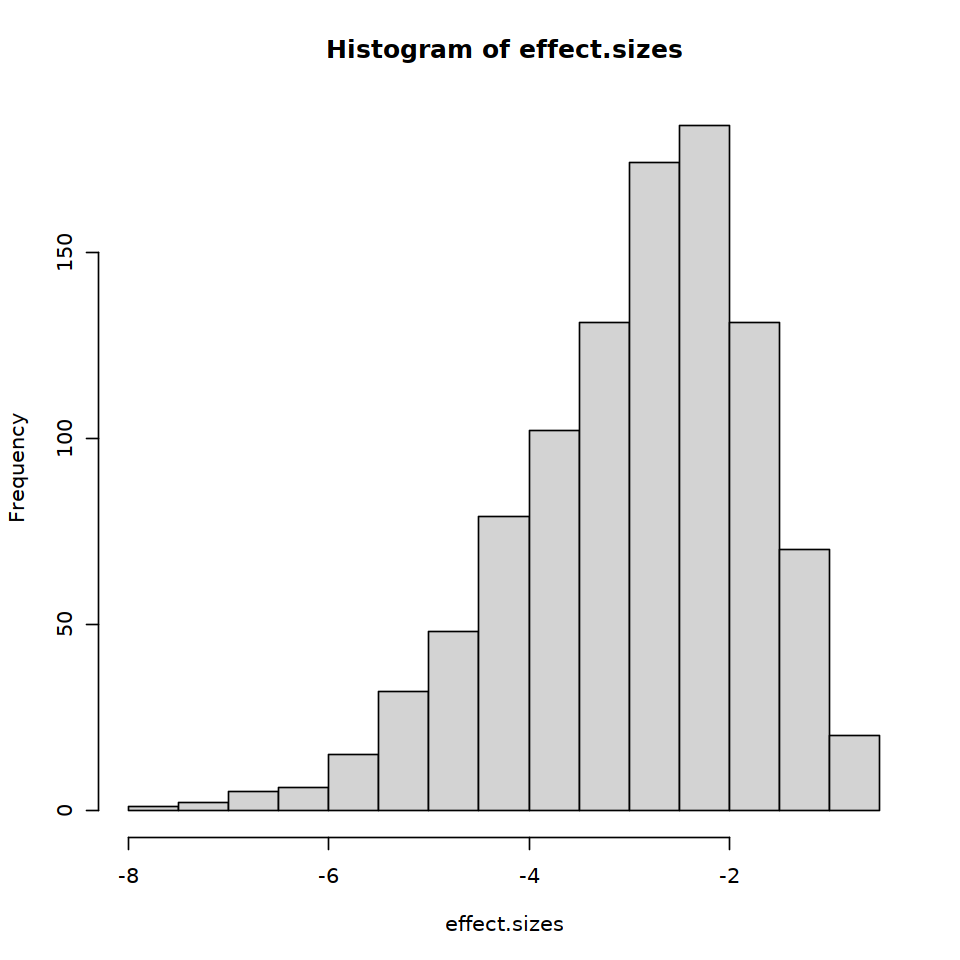

In [103]:
hist(effect.sizes)

# Get $\beta_1$ and $X_1$ values

### $\beta_1$ 

$\beta_1$ is simply a vector of length `nGenes` where each value is the effect size of the gene's enhancer on its expression. If the gene is not a target gene (not in `target.genes`) then the value of $\beta_1$ for that gene will simply be 0.

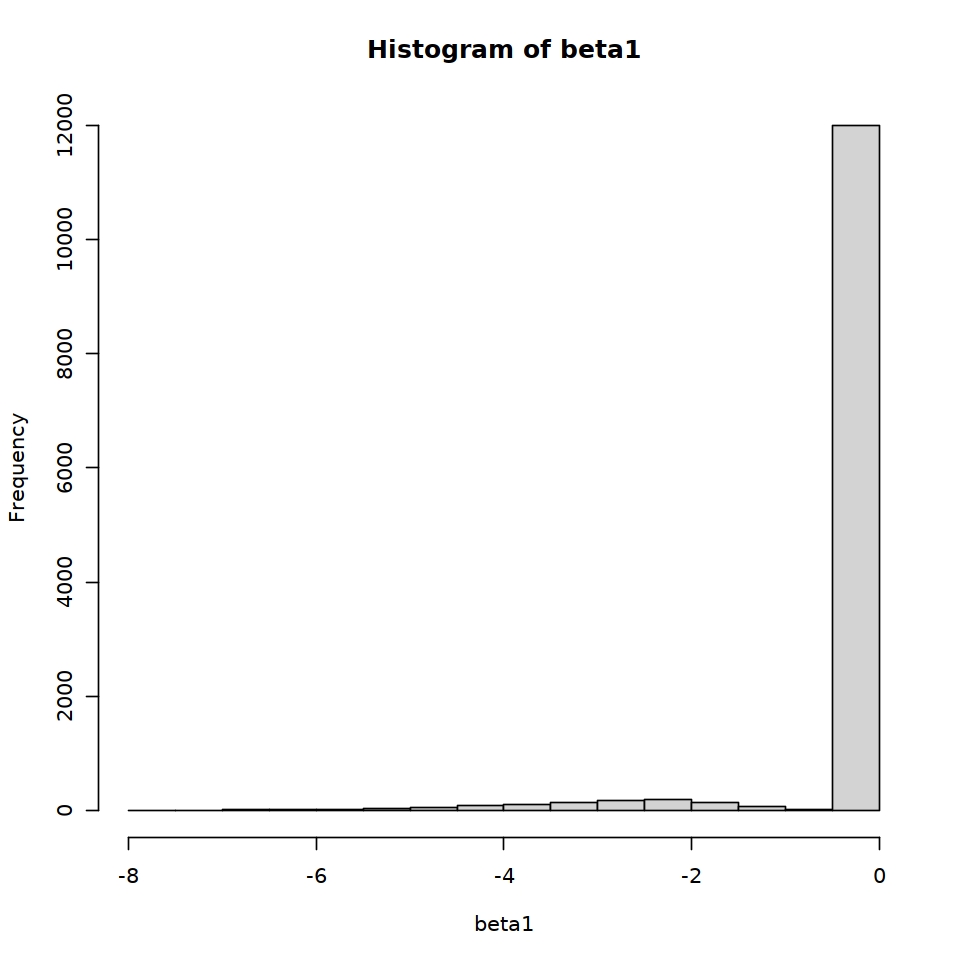

In [213]:
beta1 <- numeric(nGenes)

for (i in 1:length(target.genes)) {
    target <- target.genes[i]
    beta1[target] <- effect.sizes[i]
}

hist(beta1)

In [215]:
png("../hist_beta1.png")
hist(beta1)
dev.off()

png 
  2

### $X_1$

$X_1$ is a vector of length `nCells` where each value is a binary indicator that is a function of the presence/absence of gRNAs targeting the gene being modeled along with the efficiencies of each of these guides:

$$
    X_1 = 
\begin{cases}
    \mbox{Ber} \left(P = 1-\prod_{k=1}^{K} \left(1-g_k\right) \right),& \text{if $K\geq1$}\\
    0,              & \text{otherwise}
\end{cases}
$$

where $P$ represents the probability that the enhancer of the gene being simulated will be repressed. $K$ represents the total number of gRNAs targeting the enhancer of the gene being simulated **that are present in cell $c$** and $g_k$ is the efficiency of the $k\mbox{th}$ one of these gRNAs. 

Because this value is dependent on the gene being simulated, we cannot create a predetermined fixed vector of values. Instead, we will define a function `combined_prob` for calculating a value of $X_1$ for a given cell and gene. In this function, the variable `terms` stores a vector of values for the expression inside the product function $\left(1-g_k\right)$. Thus, the default value in `terms` is $1$, representing the case where the gRNA targeting the gene is **not** found in the cell (e.g. $g_k=0$).

In [236]:
combined_prob <- function(cell, gene, verbose = FALSE) {
    if (verbose) {
        cat(sprintf("calculating value of X1 for gene %d in cell %d\n", gene, cell))
    }
    # identify which gRNAs in our design target this gene
    guides <- which(guide.gene.map==gene)
    
    # check if any of these gRNAs are present in cell
    if (sum(onehot.guides[cell, guides]) > 0) {
        
        # default value is 1 (represents the case where the gRNA is not found in the cell) 
        terms <- rep(1, length(guides))
        
        for (i in 1:d) {
            if (onehot.guides[cell,guides[i]]!=0) {
                terms[i] <- 1-efficiencies[guides[i]]
            }
        }
        x1 <- rbinom(1,1,1-prod(terms))
        return(x1)
    } else {
        return(0)
    }
}

# Write guide metadata to table

- target gene
- guide efficiency
- effect size 

Row number references guide index

In [76]:
write.table(data.frame(guide.gene.map, efficiencies, rep(effect.sizes,2)), 
            "../sim_data_nb/metadata/guides.txt", row.names = TRUE, quote = FALSE)

# Plot $\beta_0$ against $\beta_1$

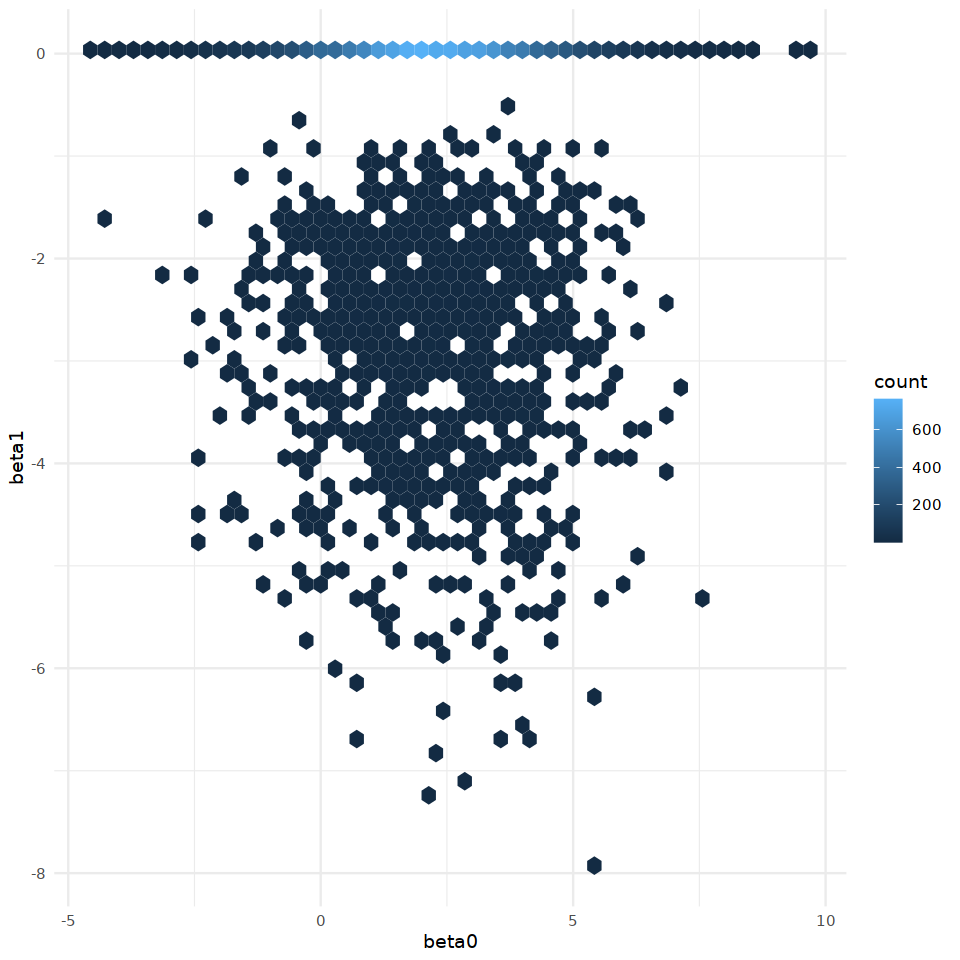

In [217]:
beta0.vs.beta1 <- data.frame(beta0=baselines, beta1=beta1)

ggplot(beta0.vs.beta1, aes(beta0,beta1)) + geom_hex(bins = 50) + theme_minimal()

In [218]:
png("../beta0_vs_beta1_hexbin.png")
ggplot(beta0.vs.beta1, aes(beta0,beta1)) + geom_hex(bins = 50) + theme_minimal()
dev.off()

png 
  2

# Use MVN to sample for cell cycle scores ($X_2, X_3$)

In [32]:
matrix(c(0.01193315, 0.001599,0.001599,0.03920382), ncol = 2)

0.01193315,0.00159900
0.00159900,0.03920382


In [123]:
matrix(c(1, -0.8,-0.8,1), ncol = 2)

1.0,-0.8
-0.8,1.0


In [131]:
rmv.rand.empirical <- rmvnorm(n=nCells, mean = c(0,0), sigma = matrix(c(0.01, 0,0,0.04), ncol = 2))
rmv.rand <- rmvnorm(n=nCells, mean = c(0,0), sigma = matrix(c(1, -0.8,-0.8,1), ncol = 2))

s.scores.emp <- rmv.rand.empirical[,1]
g2m.scores.emp <- rmv.rand.empirical[,2]

s.scores <- rmv.rand[,1]
g2m.scores <- rmv.rand[,2]

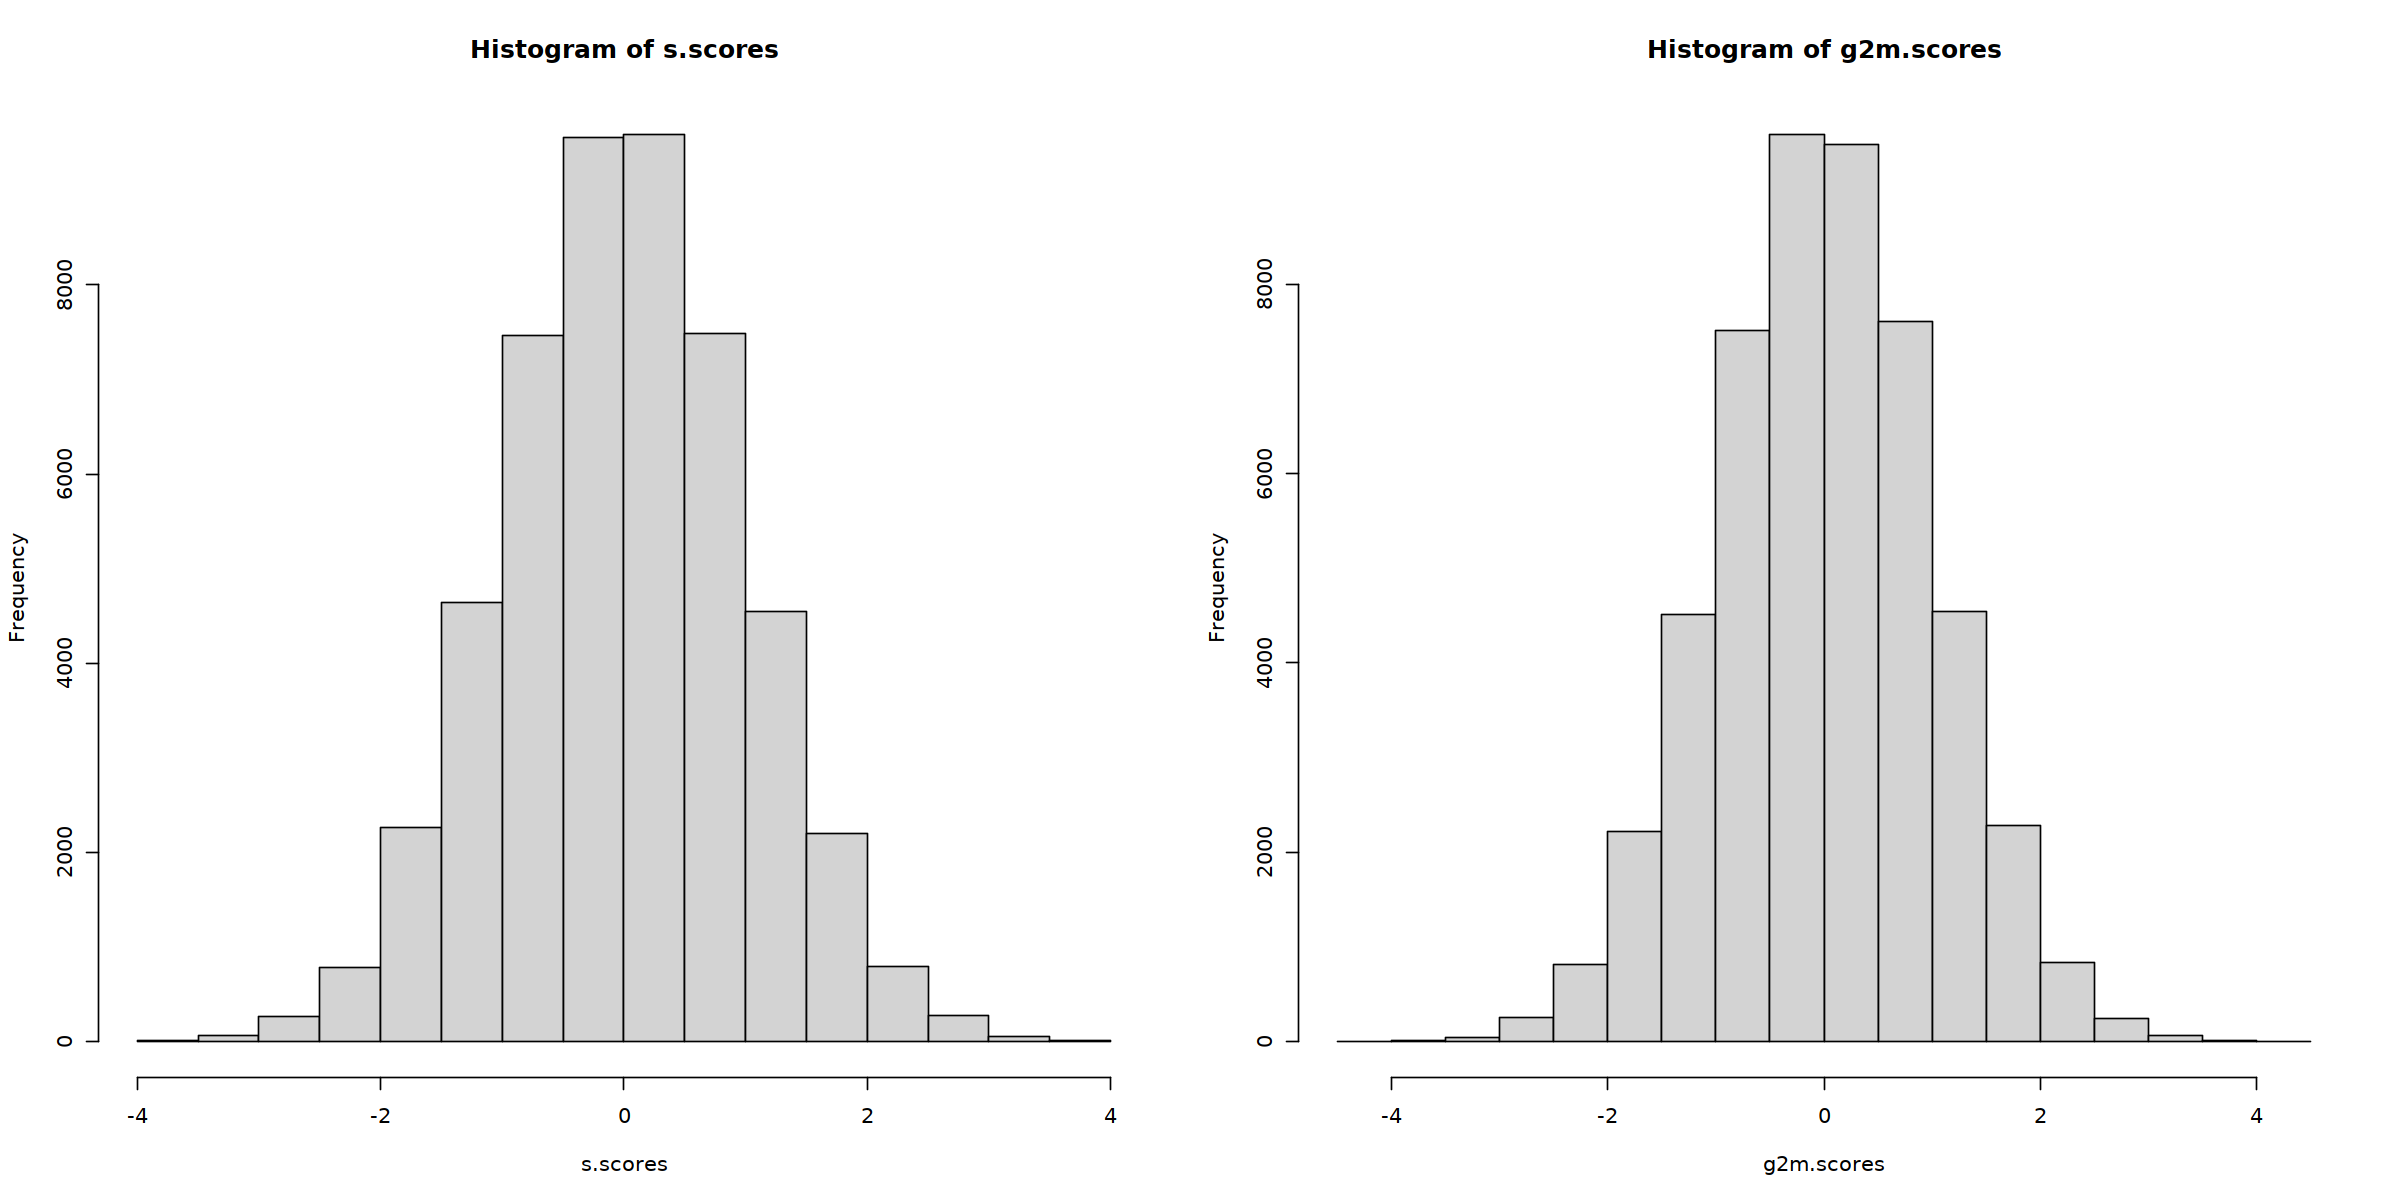

In [233]:
options(repr.plot.width=20, repr.plot.height=10)
par(mfrow = c(1,2))
hist(s.scores)
hist(g2m.scores)

In [133]:
png("../rmvnorm_s_scores.png")
hist(s.scores)
dev.off()

png("../rmvnorm_g2m_scores.png")
hist(g2m.scores)
dev.off()

png 
  2

png 
  2

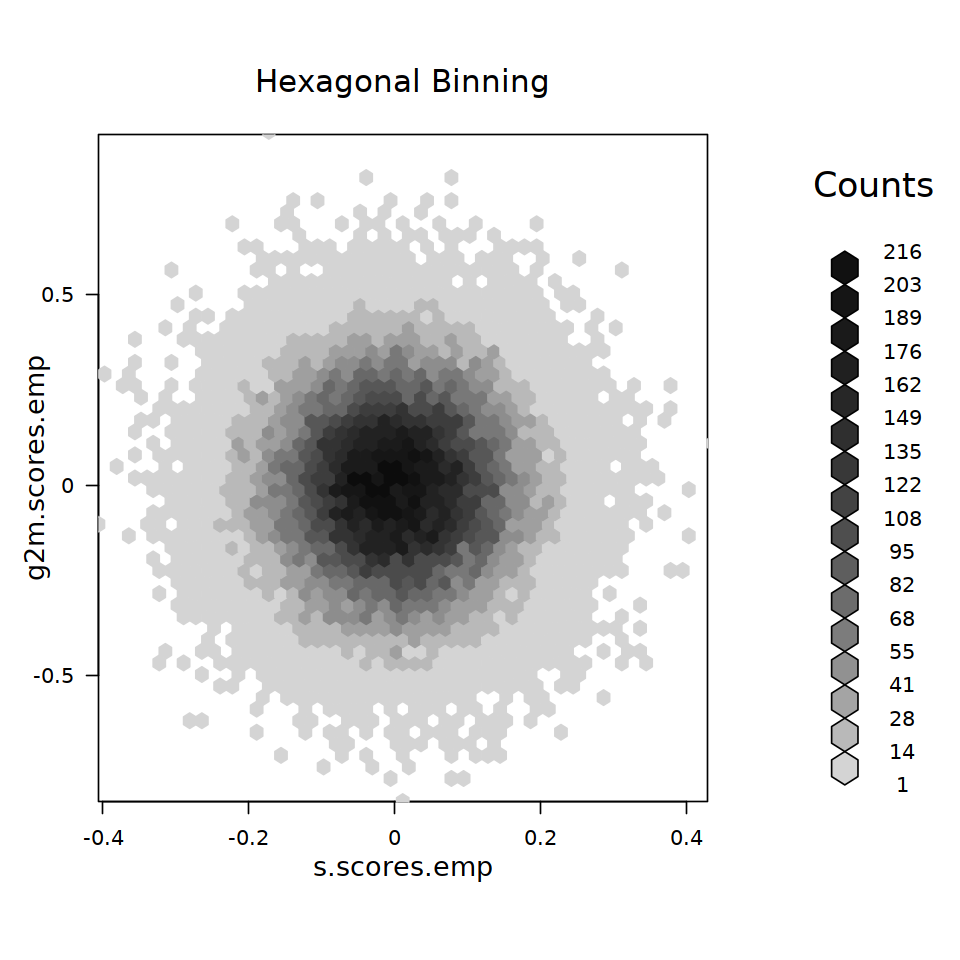

In [134]:
options(repr.plot.width=8, repr.plot.height=8)

# plot as hex
bin.emp<-hexbin(s.scores.emp, g2m.scores.emp, xbins=50)
plot(bin.emp, main="Hexagonal Binning")

In [142]:
png("../cell_cycle_scores_hexbin_emp.png")
plot(bin.emp, main="Hexagonal Binning")
dev.off()

png 
  2

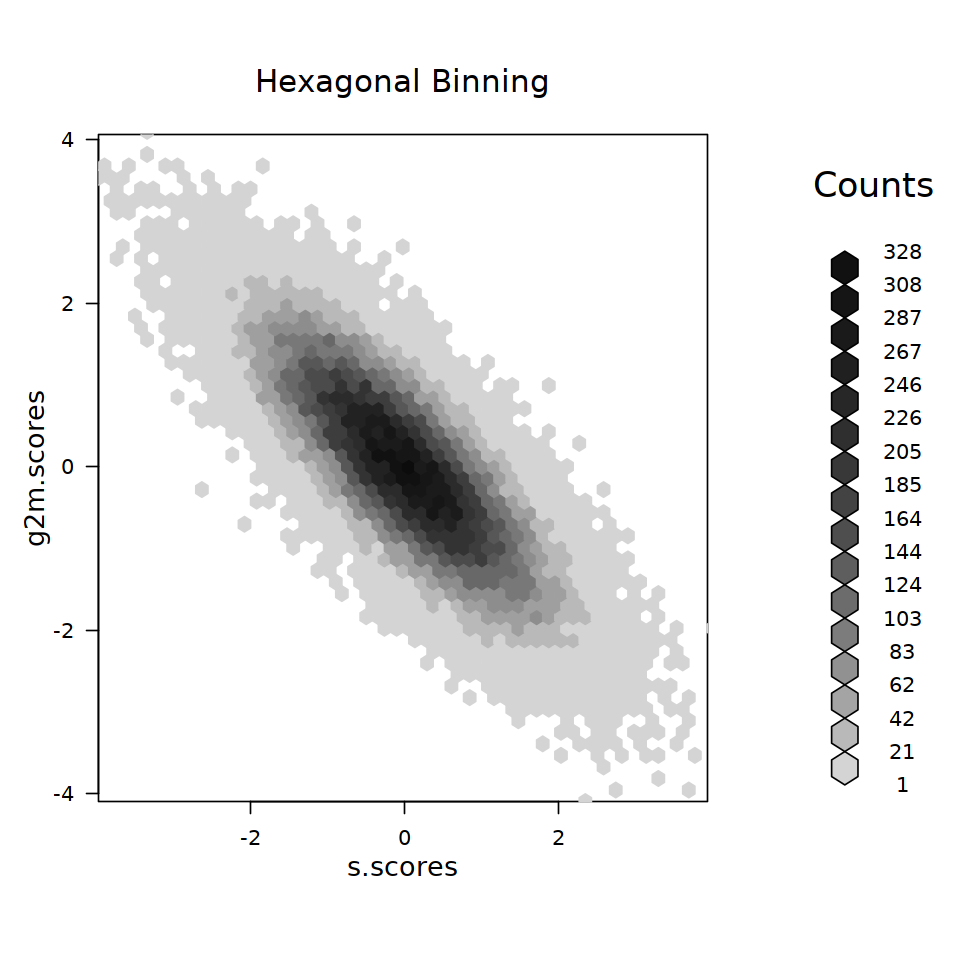

In [143]:
# plot as hex
bin<-hexbin(s.scores, g2m.scores, xbins=50)
plot(bin, main="Hexagonal Binning")

In [144]:
png("../cell_cycle_scores_hexbin.png")
plot(bin, main="Hexagonal Binning")
dev.off()

png 
  2

# Select $\beta_2, \beta_3$

Draw from the same distribution as enhancer effect sizes

In [152]:
beta2 <- rgamma(nGenes, shape = 6, scale = 0.5)
beta3 <- rgamma(nGenes, shape =6, scale = 0.5)

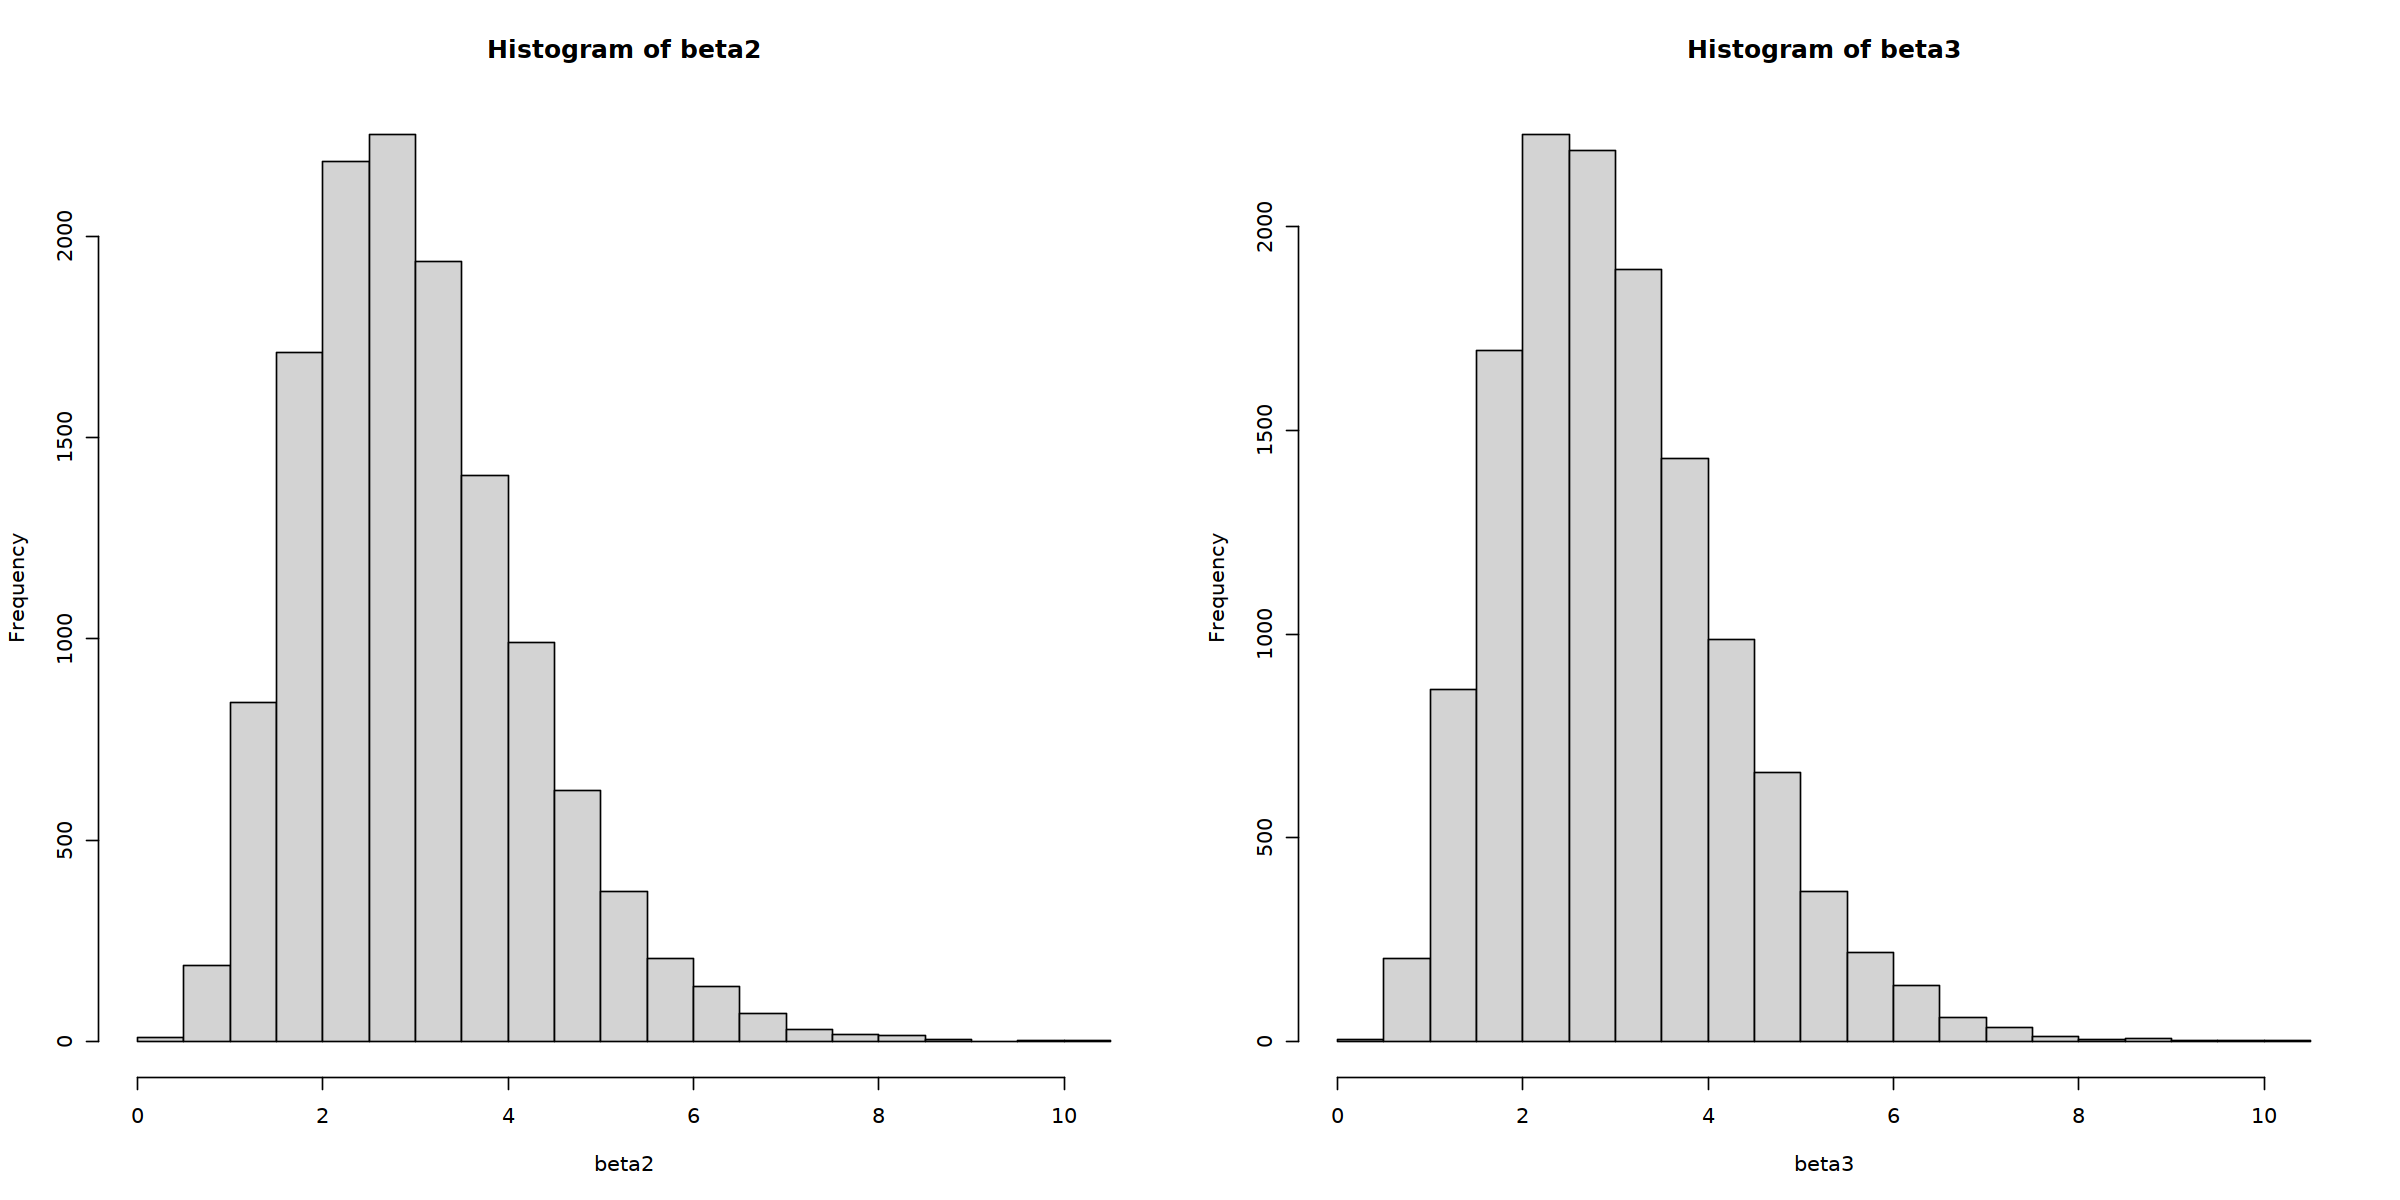

In [234]:
options(repr.plot.width=20, repr.plot.height=10)
par(mfrow=c(1,2))
hist(beta2)
hist(beta3)

In [154]:
png("../beta2_hist.png")
hist(beta2)
dev.off()

png("../beta3_hist.png")
hist(beta3)
dev.off()

png 
  2

png 
  2

# Scaling factors
We will define a fixed vector of cell-specific scaling factors as $\mathbf{s}=\frac{T_i}{1e6} \forall i \in 1,...,C$ where $T_i$ represents the total counts in a cell and $C$ is the total number of cells.

In the case of simulating data, we have a chicken and egg problem since we have yet to simulate the counts and therefore do not have $T_i$. Instead, we will draw $T_i$ from $\mbox{Pois} \left(50000 \right)$ to represent that 50,000 counts is a reasonable number to expect in a cell in an scRNA-seq experiment ([link](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://ucdavis-bioinformatics-training.github.io/2017_2018-single-cell-RNA-sequencing-Workshop-UCD_UCB_UCSF/day3/singlecellRNAseq-expDesign.pdf)).

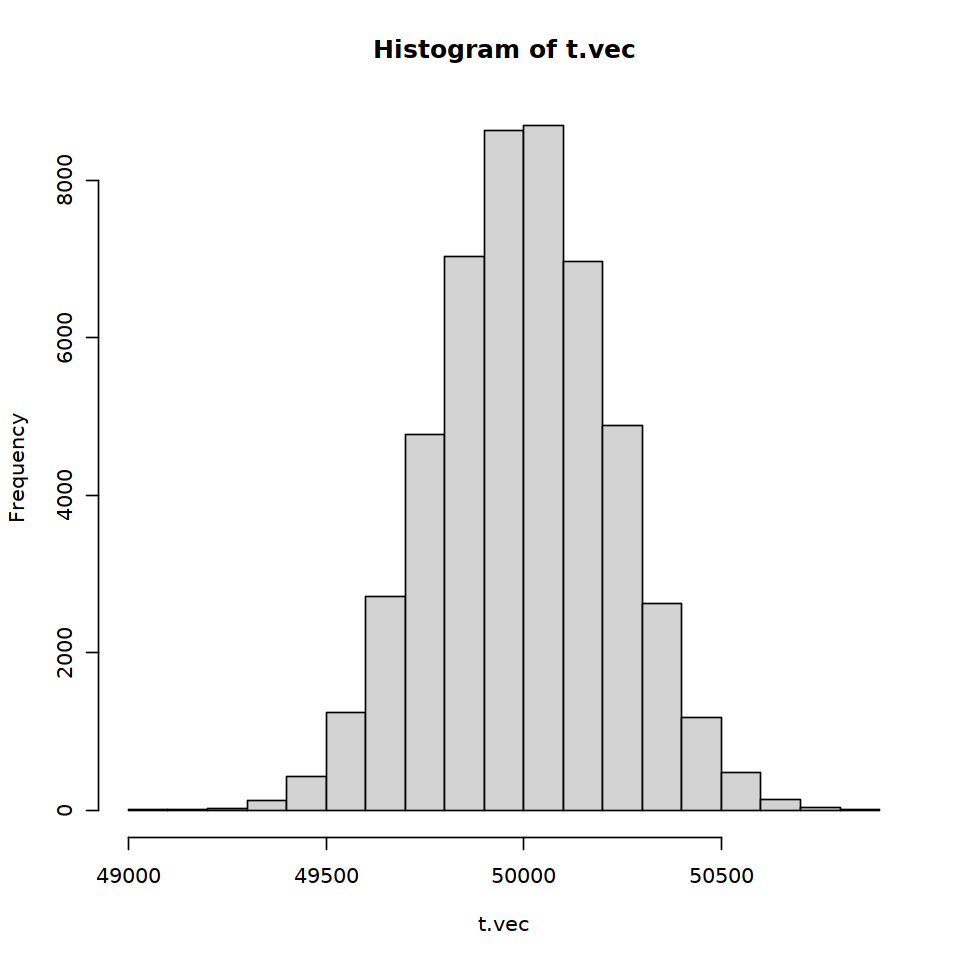

In [155]:
options(repr.plot.width=8, repr.plot.height=8)

t.vec <- rpois(nCells, 50000)
hist(t.vec)

In [156]:
png("../t_pois_hist.png")
hist(t.vec)
dev.off()

png 
  2

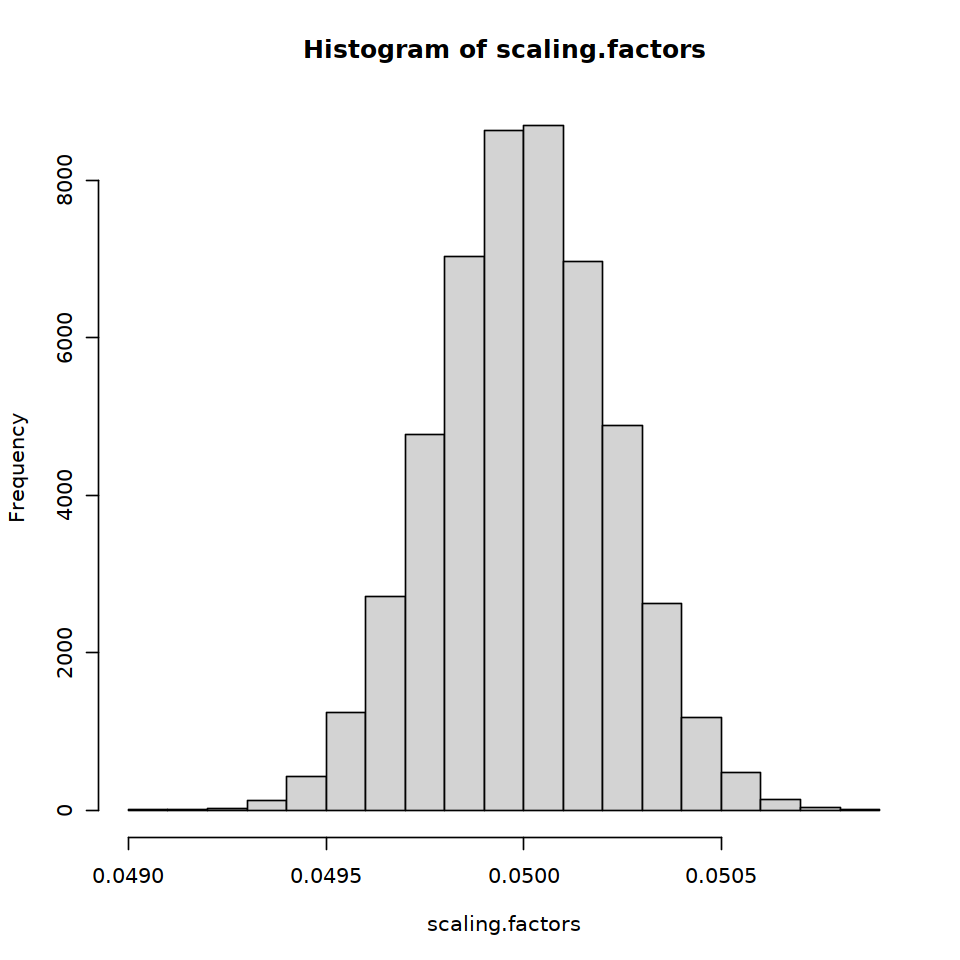

In [157]:
scaling.factors <- t.vec/1e6
hist(scaling.factors)

In [158]:
png("../scaling_factors_hist.png")
hist(scaling.factors)
dev.off()

png 
  2

# Simulate data

In [237]:
# initialize counts matrix
sim.counts <-  matrix(0, nGenes, nCells)

# populate counts mtx by gene (by row)
for (gene in 1:nGenes) {
    # get coeffs
    b0 <- baselines[gene]
    b1 <- beta1[gene]
    b2 <- beta2[gene]
    b3 <- beta3[gene]
    
    # initialize x1 as vector of zeros (assume it will not be affected by any guides in library)
    x1 <- numeric(nCells)
    
    # check if enhancer of gene is targeted by any guides in our library
    if (gene %in% target.genes) {
        for (i in 1:nCells) {
            x1[i] <- combined_prob(i, gene)
        }
    }
    
    # get cell cycle scores
    x2 <- s.scores
    x3 <- g2m.scores
    
    # calculate values of mu
    mu.vec <- scaling.factors*exp(b0 + b1*x1 + b2*x2 + b3*x3)
    
    # use rnbinom to generate counts of each cell for this gene and update counts matrix
#     counts <- sapply(mu.vec, function(x) {rnbinom(1, mu = x, size = 1.5)})
    counts <- rnbinom(length(mu.vec), mu = mu.vec, size = 1.5)
    sim.counts[gene,] <- counts
}

Visualize row (genes) and column (cells) sums (logarithmic scale)

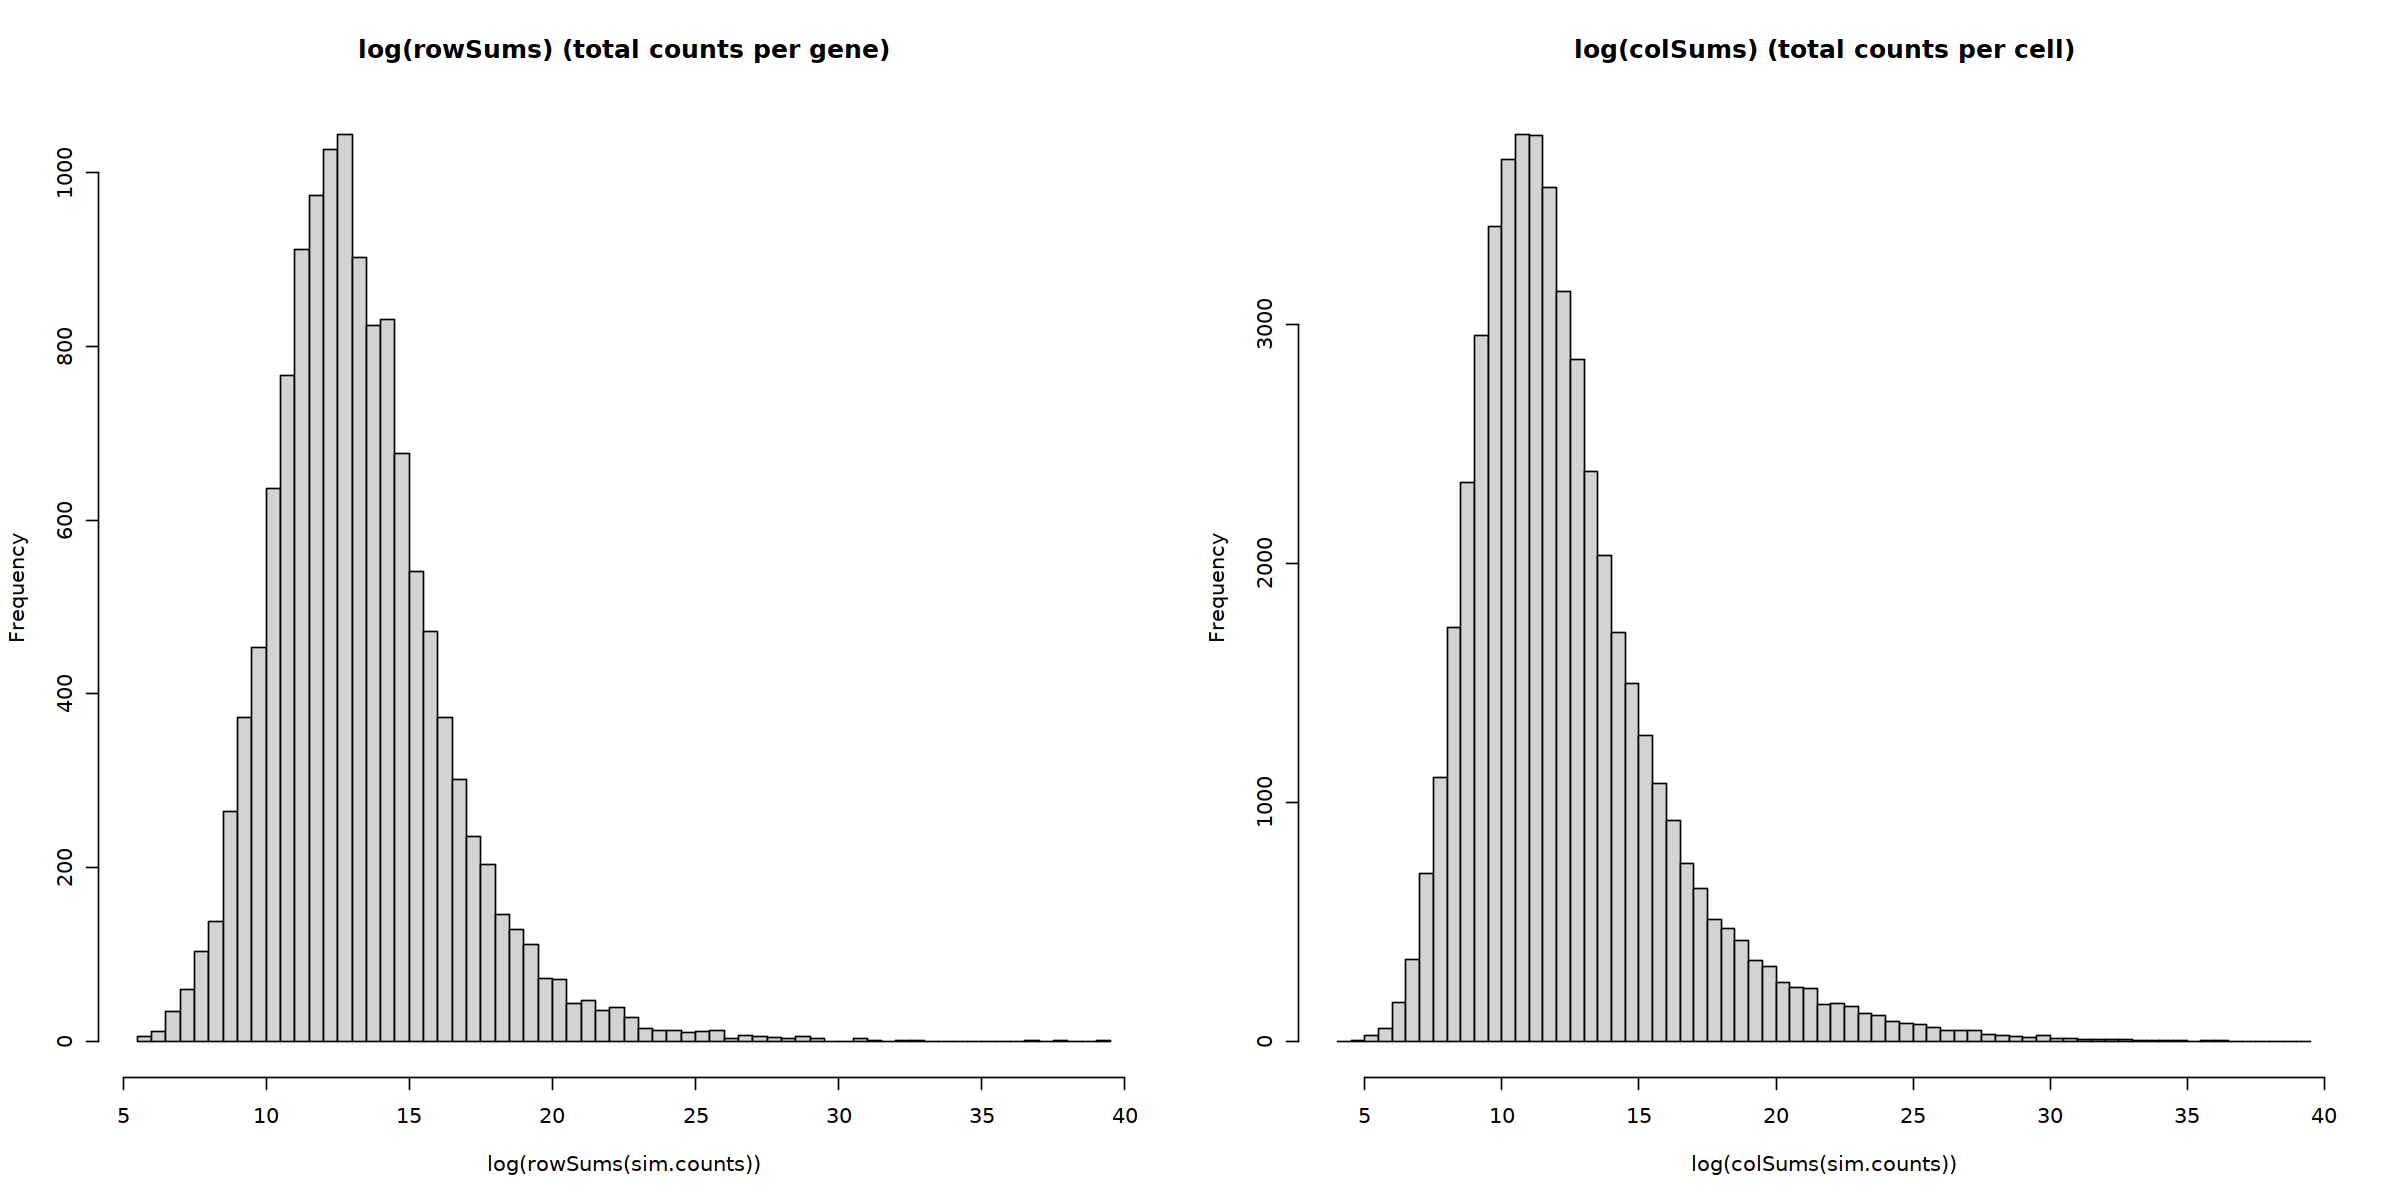

In [241]:
options(repr.plot.width=20, repr.plot.height=10)
par(mfrow=c(1,2))
hist(log(rowSums(sim.counts)), breaks = 100, main = "log(rowSums) (total counts per gene)")
hist(log(colSums(sim.counts)),breaks = 100, main = "log(colSums) (total counts per cell)")

Save plots

In [242]:
png("../sim_log_rowSums.png")
hist(log(rowSums(sim.counts)), breaks = 100, main = "log(rowSums) (total counts per gene)")
dev.off()

png 
  2

In [243]:
png("../sim_log_colSums.png")
hist(log(colSums(sim.counts)),breaks = 100, main = "log(colSums) (total counts per cell)")
dev.off()

png 
  2